In [1]:
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,Conv1D, GlobalMaxPooling1D,Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
trainname = "train.tsv"
evlname = "dev.tsv"
testname = "test.tsv"
trainset = pd.read_csv("./dataset/SST-2/"+trainname,sep="\t",error_bad_lines = False).drop_duplicates()

evlset = pd.read_csv("./dataset/SST-2/"+evlname,sep="\t",error_bad_lines = False).drop_duplicates()

testset = pd.read_csv("./dataset/SST-2/"+testname,sep="\t",error_bad_lines = False,quoting = csv.QUOTE_NONE).drop_duplicates()

trainset.head(5)

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [3]:
import torch

# 禁用GPU，将所有张量放置在CPU上
device = torch.device("cpu")

In [4]:
evlset.head(5)

,sentence,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0


In [5]:
testset.head(5)

,index,sentence
0,0,uneasy mishmash of styles and genres .
1,1,this film 's relationship to actual tension is...
2,2,"by the end of no such thing the audience , lik..."
3,3,director rob marshall went out gunning to make...
4,4,lathan and diggs have considerable personal ch...


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
train_set = trainset.drop_duplicates()
test_set = evlset.drop_duplicates()

In [7]:
train_set.columns = ['verse_text','label']
test_set.columns = ['verse_text','label']
def transtoDict(train_set):
    train_set_bert = []
    ver_text = train_set['verse_text']
    ver_label = train_set['label']
    for text,label in dict(zip(ver_text,ver_label)).items():
        train_set_bert.append({'text':text,
                              'label':label})
    return train_set_bert
train_set_bert = transtoDict(train_set)
test_set_bert = train_set_bert[int(len(train_set_bert)*0.9):len(train_set_bert)]
train_set_bert = train_set_bert[0:int(len(train_set_bert)*0.4)]
test_set_bert_real = transtoDict(test_set)
ver_text = []
ver_label = []
for sample in train_set_bert:
    ver_text.append(sample['text'])
    ver_label.append(sample['label'])
train_text = ver_text
train_label = ver_label
ver_test_text = []
ver_test_label = []
for sample in test_set_bert:
    ver_test_text.append(sample['text'])
    ver_test_label.append(sample['label'])
test_text = ver_test_text
test_label = ver_test_label
test_text_real = []
test_label_real = []
for sample in test_set_bert_real:
    test_text_real.append(sample['text'])
    test_label_real.append(sample['label'])
all_text = train_text + test_text + test_text_real

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts((all_text))
sequences = tokenizer.texts_to_sequences(train_text)
max_length = max(len(sequence) for sequence in sequences)
token_seq = pad_sequences(sequences, maxlen=max_length, padding='post')

In [9]:
test_sequences_real = tokenizer.texts_to_sequences(test_text_real)
test_sequences_real = pad_sequences(test_sequences_real, maxlen=max_length, padding='post')

In [10]:
test_sequences = tokenizer.texts_to_sequences(test_text)
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [11]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion = 'entropy',max_depth = 128,random_state=0)
dtc.fit(token_seq,train_label)
pre_dtc = dtc.predict(test_sequences)
print(classification_report(test_label, pre_dtc))
acc_dtc = accuracy_score(test_label, pre_dtc)
print(f'Accuracy = {acc_dtc}')

prec = precision_score(test_label,pre_dtc, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, pre_dtc, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, pre_dtc, average='macro')
print(f'F1 score (macro average) = {f1}')
print(f'Total example:{len(pre_dtc)}, We have {sum(pre_dtc)} postive examples.')

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      2955
           1       0.64      0.64      0.64      3743

    accuracy                           0.60      6698
   macro avg       0.59      0.59      0.59      6698
weighted avg       0.60      0.60      0.60      6698

Accuracy = 0.5989847715736041
Precision (macro average) = 0.5935370056508145
Recall (macro average) = 0.5936414640662571
F1 score (macro average) = 0.5935857729489225
Total example:6698, We have 3727 postive examples.


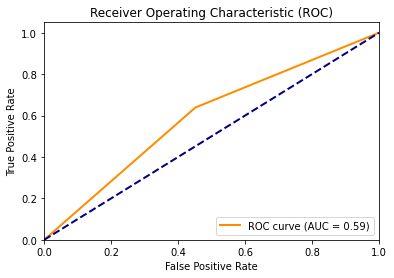

In [12]:
pre_dtc_prob = dtc.predict_proba(test_sequences)[:,1]
fpr, tpr, _ = roc_curve(test_label, pre_dtc_prob)
roc_auc = roc_auc_score(test_label, pre_dtc_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [13]:
####Time cost prediction Dtc####
time_dtc = []
time_test_dtc = []
train_dtc_ans = []
test_dtc_ans = []
for text in token_seq:
    start_time = time.time()
    train_dtc_ans.append(dtc.predict(np.expand_dims(text,0)))
    time_dtc.append(time.time() - start_time)
print(f'Completes processing {len(token_seq)} samples.Cost time: {sum(time_dtc)}')
for text in test_sequences:
    start_time = time.time()
    test_dtc_ans.append(dtc.predict(np.expand_dims(text,0)))
    time_test_dtc.append(time.time() - start_time)
print(f'Completes processing {len(test_sequences)} samples.Cost time: {sum(time_test_dtc)}')

Completes processing 26791 samples.Cost time: 1.4102675914764404
Completes processing 6698 samples.Cost time: 0.37699460983276367


In [14]:
real_dtc_test = dtc.predict(test_sequences_real)

In [15]:
max_depth_list = [4,8,10,20,30,50,75,100,200,300,500]
best_depth = 0
best_loss = 99999
for depth in max_depth_list:
    dtr_dtc = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr_dtc.fit(token_seq,time_dtc)
    time_predict_dtc = dtr_dtc.predict(test_sequences)
    loss = sum(abs(np.array(time_predict_dtc - time_test_dtc)**2))
    if best_loss>loss:
        best_loss = loss
        best_depth = depth
print(best_depth)
dtr_dtc = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dtr_dtc.fit(token_seq,time_dtc)
time_predict_dtc = dtr_dtc.predict(test_sequences)
time_list = pd.DataFrame({'Pre':time_predict_dtc,
                         'Truth':time_test_dtc})
print(sum(time_predict_dtc))
time_list.head(10)

4
0.3547050615865239


,Pre,Truth
0,0.000053,0.0
1,0.000053,0.0
2,0.000053,0.0
3,0.000053,0.0
4,0.000053,0.0
5,0.000053,0.0
6,0.000053,0.0
7,0.000053,0.0
8,0.000053,0.0
9,0.000053,0.0


In [16]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
model_new = AutoModelForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D",num_labels = 2)
tokenizer_pre = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
def creatDataset(train_data,tensor_return):
    input_ids_list = []
    attention_mask_list = []
    labels = []
    for sample in train_data:
        encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
        input_ids_list.append(encoded_inputs['input_ids'].squeeze())
        attention_mask_list.append(encoded_inputs['attention_mask'].squeeze())
        labels.append(sample['label'])
    print(f'Completes, totally {len(train_data)} samples proceeded.')
    input_ids_tensor = torch.stack(input_ids_list)
    attention_mask_tensor = torch.stack(attention_mask_list)
    labels_tensor = torch.tensor(labels)
    train_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    if tensor_return:
        return train_loader,input_ids_tensor,attention_mask_tensor,labels_tensor
    else:
        return train_loader
train_loader = creatDataset(train_set_bert,False)
test_loader,test_input,test_am,test_l= creatDataset(test_set_bert,True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completes, totally 26791 samples proceeded.
Completes, totally 6698 samples proceeded.


In [17]:
device = 'cpu'

In [18]:
# 定义损失函数和优化器
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_new.parameters(), lr=2e-5)

# 开始训练
model_new.train()
for param in model_new.bert.parameters():
    param.requires_grad = True

for epoch in range(15):
    start_time = time.time()
    for batch in train_loader:
        inputs, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model_new(input_ids=inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1} completes, cost time: {time.time()-start_time}')

Epoch 1 completes, cost time: 395.5067067146301
Epoch 2 completes, cost time: 409.0104637145996
Epoch 3 completes, cost time: 424.04146575927734
Epoch 4 completes, cost time: 409.5997643470764
Epoch 5 completes, cost time: 424.74215507507324
Epoch 6 completes, cost time: 412.86442041397095
Epoch 7 completes, cost time: 410.2856698036194
Epoch 8 completes, cost time: 400.7676351070404
Epoch 9 completes, cost time: 404.3139441013336
Epoch 10 completes, cost time: 404.35300493240356
Epoch 11 completes, cost time: 398.9581232070923
Epoch 12 completes, cost time: 400.87004923820496
Epoch 13 completes, cost time: 398.88320112228394
Epoch 14 completes, cost time: 399.3806290626526
Epoch 15 completes, cost time: 402.1370015144348


In [19]:
model_new.save_pretrained('./dataset/SST-2')
tokenizer_pre.save_pretrained('./dataset/SST-2')

('./dataset/SST-2\\tokenizer_config.json',
 './dataset/SST-2\\special_tokens_map.json',
 './dataset/SST-2\\vocab.txt',
 './dataset/SST-2\\added_tokens.json',
 './dataset/SST-2\\tokenizer.json')

In [20]:
model_new = AutoModelForSequenceClassification.from_pretrained('./dataset/SST-2')
tokenizer_pre = AutoTokenizer.from_pretrained('./dataset/SST-2')

In [21]:
def predict_nn(trained_model, test_input,test_am):
    start_time = time.time()
    # Switch off dropout
    trained_model.eval()

    # Pass the required items from the dataset to the model
    output = trained_model(input_ids=test_input,attention_mask=test_am)

    # the output dictionary contains logits, which are the unnormalised scores for each class for each example:
    pred_labs = np.argmax(output["logits"].detach().numpy(), axis=1)
    return pred_labs


In [22]:
def predict_prob(trained_model, test_input,test_am):
    start_time = time.time()
    # Switch off dropout
    trained_model.eval()

    # Pass the required items from the dataset to the model
    output = trained_model(input_ids=test_input,attention_mask=test_am)

    # the output dictionary contains logits, which are the unnormalised scores for each class for each example:
    return output

In [ ]:
predictions = predict_nn(model_new,test_input,test_am)

In [ ]:
acc_tbert = accuracy_score(test_l.detach().numpy(), predictions)
print(f'Accuracy = {acc_tbert}')

prec = precision_score(test_l.detach().numpy(), predictions, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_l.detach().numpy(), predictions, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_l.detach().numpy(), predictions, average='macro')
print(f'F1 score (macro average) = {f1}')
print(classification_report(test_l.detach().numpy(), predictions))

In [ ]:
##Time cost calculation Bert##
import tqdm
####TinyBert#####
time_Bert = []
train_bert_ans = []
start_time = time.time()
print(f'Totally {len(train_set_bert)} samples.')
for sample in train_set_bert:
    encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
    ids_tensor=encoded_inputs['input_ids']
    am_tensor=encoded_inputs['attention_mask']
    model_new.to('cpu')
    predictions = predict_nn(model_new,ids_tensor,am_tensor)
    train_bert_ans.append(predictions)
    time_Bert.append((time.time()-start_time))
    start_time = time.time()
print(f'Completes.Cost time: {sum(time_Bert)}')

In [ ]:
test_time_Bert = []
test_bert_ans = []
start_time = time.time()
print(f'Totally {len(test_set_bert)} samples.')
for sample in test_set_bert:
    encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
    ids_tensor=encoded_inputs['input_ids']
    am_tensor=encoded_inputs['attention_mask']
    model_new.to('cpu')
    predictions = predict_nn(model_new,ids_tensor,am_tensor)
    test_bert_ans.append(predictions)
    test_time_Bert.append((time.time()-start_time))
    start_time = time.time()
print(f'Completes.Cost time: {sum(test_time_Bert)}')

In [ ]:
max_depth_list = [4,8,10,20,30,50,75,100,200,300,500]
best_depth = 0
best_loss = 99999
for depth in max_depth_list:
    dtr = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr.fit(token_seq,time_Bert)
    time_predict_bert = dtr.predict(test_sequences)
    loss = sum(abs(np.array(time_predict_bert - test_time_Bert)**2))
    if best_loss>loss:
        best_loss = loss
        best_depth = depth
print(best_depth)
dtr = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dtr.fit(token_seq,time_Bert)
time_predict_bert = dtr.predict(test_sequences)
time_list = pd.DataFrame({'Pre':time_predict_bert,
                         'Truth':test_time_Bert})
print(sum(time_predict_bert))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
knn_model = KNeighborsClassifier(8)
knn_model.fit(token_seq,train_label)
y_pred = knn_model.predict(test_sequences)

In [ ]:
acc_knn = accuracy_score(test_label, y_pred)
print(f'Accuracy = {acc_knn}')

prec = precision_score(test_label, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label, y_pred))

In [ ]:
##Time cost calculation Knn##
time_K = []
train_ans_knn = []
test_ans_knn = []
start_time = time.time()
print(f'Totally {len(train_text)} samples.')
for text_seq in token_seq:
    pre_knn = knn_model.predict(np.expand_dims(text_seq,0))
    time_K.append(time.time()-start_time)
    start_time = time.time()
    train_ans_knn.append(pre_knn)
print(f'Completes.Cost time: {sum(time_K)}')
time_test_K = []
start_time = time.time()
print(f'Totally {len(test_text)} samples.')
for text_seq in test_sequences:
    pre_knn = knn_model.predict(np.expand_dims(text_seq,0))
    time_test_K.append(time.time()-start_time)
    start_time = time.time()
    test_ans_knn.append(pre_knn)
print(f'Completes.Cost time: {sum(time_test_K)}')

In [ ]:
best_depth = 0
best_loss = 99999
for depth in max_depth_list:
    dtr_knn = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr_knn.fit(token_seq,time_K)
    time_predict_knn = dtr_knn.predict(test_sequences)
    loss = sum(abs(np.array(time_predict_knn - time_test_K)**2))
    if best_loss>loss:
        best_loss = loss
        best_depth = depth
print(best_depth)
dtr_knn = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dtr_knn.fit(token_seq,time_K)
time_predict_knn = dtr_knn.predict(test_sequences)
time_list = pd.DataFrame({'Pre':time_predict_knn,
                         'Truth':time_test_K})
print(sum(time_predict_knn))

In [ ]:
#####Accuracy Predicator######
def acclist(ans,truth):
    truth_list = []
    for a,b in zip(ans,truth):
        if a !=b:
            truth_list.append(0)
        else:
            truth_list.append(1)
    return truth_list
acclist_knn = acclist(train_ans_knn,train_label)
acclist_bert = acclist(train_bert_ans,train_label)
acclist_knn_test = acclist(test_ans_knn,test_label)
acclist_bert_test = acclist(test_bert_ans,test_label)
depth_list = np.linspace(1,20,20,dtype = int)
best_depth_knn = 1
best_depth_bert = 1
acc_knn = 0
acc_bert = 0
for i in depth_list:
    acc_pre_knn = KNeighborsClassifier(i)
    acc_pre_bert = KNeighborsClassifier(i)
    acc_pre_knn.fit(token_seq,acclist_knn)
    acc_pre_bert.fit(token_seq,acclist_bert)
    acc_ans_knn = acc_pre_knn.predict_proba(test_sequences)[:,1]
    acc_ans_bert = acc_pre_bert.predict_proba(test_sequences)[:,1]
    temp_knn = roc_auc_score(acclist_knn_test, acc_ans_knn)
    temp_bert = roc_auc_score(acclist_bert_test, acc_ans_bert)
    best_depth_knn = (i if temp_knn < acc_knn else best_depth_knn)
    acc_knn = temp_knn
    best_depth_bert =( i if temp_bert < acc_bert else best_depth_bert)
    acc_bert = temp_bert
print(best_depth_knn)
print(best_depth_bert)

In [ ]:
acclist_dtc = acclist(test_dtc_ans,test_label)
acclist_dtc_test = acclist(real_dtc_test,test_label_real)
for i in depth_list:
    acc_pre_dtc = KNeighborsClassifier(i)
    acc_pre_dtc.fit(test_sequences,acclist_dtc)
    acc_ans_dtc = acc_pre_dtc.predict_proba(test_sequences_real)[:,1]
    temp_dtc = roc_auc_score(acclist_dtc_test, acc_ans_dtc)
    best_depth_dtc = (i if temp_dtc < acc_dtc else best_depth_dtc)
print(best_depth_dtc)
acc_pre_dtc = KNeighborsClassifier(best_depth_dtc)
acc_pre_dtc.fit(test_sequences,acclist_dtc)
acc_ans_dtc = acc_pre_dtc.predict(test_sequences)
print(classification_report(acclist_dtc, acc_ans_dtc))
acc_ans_dtc = acc_pre_dtc.predict_proba(test_sequences)[:,1]

In [ ]:
acc_pre_knn = KNeighborsClassifier(best_depth_knn)
acc_pre_bert = KNeighborsClassifier(best_depth_bert)
acc_pre_knn.fit(token_seq,acclist_knn)
acc_pre_bert.fit(token_seq,acclist_bert)
acc_ans_knn = acc_pre_knn.predict(test_sequences)
acc_ans_bert = acc_pre_bert.predict(test_sequences)
print(classification_report(acclist_knn_test, acc_ans_knn))
print(classification_report(acclist_bert_test, acc_ans_bert))

In [ ]:
####Check area#####
check_list_knn = pd.DataFrame({'Pred':test_ans_knn,
                              'Truth':test_label,
                              'Acc':acclist_knn_test,
                              'Acc Pre':acc_ans_knn})
check_list_knn.head(10)
check_list_bert = pd.DataFrame({'Pred':test_bert_ans,
                              'Truth':test_label,
                              'Acc':acclist_bert_test,
                              'Acc Pre':acc_ans_bert})
check_list_bert.head(10)

In [ ]:
def utility(accw,acc,costw,cost):
    return (acc*accw - cost*costw)

In [ ]:
accw = 0.1
cost_list = np.append(np.linspace(1e-1,1,50),np.linspace(1,8,40))
#cost_list = np.append(cost_list,np.linspace(1,10,50))
cost_list[0] = 0
acc_list = []
time_list = []
model_list = []
F1_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert:
        time_knn_use = dtr_knn.predict(np.expand_dims(test_sequences[count],0))
        time_bert_use = dtr.predict(np.expand_dims(test_sequences[count],0))
        acc_knn = acc_pre_knn.predict_proba(np.expand_dims(test_sequences[count],0))[:, 1]
        acc_tbert = acc_pre_bert.predict_proba(np.expand_dims(test_sequences[count],0))[:, 1]
        uti_knn = utility(accw,acc_knn,costw,time_knn_use)
        uti_bert = utility(accw,acc_tbert,costw,time_bert_use)
        start_time= time.time()
        if(uti_knn > uti_bert):
            result_pre.append(knn_model.predict(np.expand_dims(test_sequences[count],0)))
            model_select.append(0)
        else:
            encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
            ids_tensor=encoded_inputs['input_ids']
            am_tensor=encoded_inputs['attention_mask']
            model_new.to('cpu')
            result_pre.append(predict_nn(model_new,ids_tensor,am_tensor))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

In [ ]:
#acc_time.head(len(cost_list))
acc_time.head(150)

In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(min(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(acc_time[acc_time['Time'] == max(temp_time)]['Cost'])
for mintime in uni_time:
    uni_model.append(acc_time[acc_time['Time'] == mintime]['Model'])
print(uni_acc)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(uni_time,uni_acc)
plt.legend

In [ ]:
uni_frame = pd.DataFrame({'Time':uni_time,
              'Acc':uni_acc,
              'Selection':uni_model
})
uni_frame.head(30)

In [ ]:
acc_list = []
time_list = []
F1_list = []
model_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert_real:
        time_knn_use = dtr_knn.predict(np.expand_dims(test_sequences_real[count],0))
        time_bert_use = dtr.predict(np.expand_dims(test_sequences_real[count],0))
        acc_knn = acc_pre_knn.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        acc_tbert = acc_pre_bert.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        uti_knn = utility(accw,acc_knn,costw,time_knn_use)
        uti_bert = utility(accw,acc_tbert,costw,time_bert_use)
        start_time= time.time()
        if(uti_knn > uti_bert):
            result_pre.append(knn_model.predict(np.expand_dims(test_sequences_real[count],0)))
            model_select.append(0)
        else:
            encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
            ids_tensor=encoded_inputs['input_ids']
            am_tensor=encoded_inputs['attention_mask']
            model_new.to('cpu')
            result_pre.append(predict_nn(model_new,ids_tensor,am_tensor))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label_real, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label_real, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

In [ ]:
print(len(test_label_real))

In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(min(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(acc_time[acc_time['Time'] == max(temp_time)]['Cost'])
for mintime in uni_time:
    uni_model.append(acc_time[acc_time['Time'] == mintime]['Model'])
print(uni_acc)
plt.plot(uni_time,uni_acc)
plt.show

In [ ]:
uni_frame = pd.DataFrame({'Time':uni_time,
              'Acc':uni_acc,
})
uni_frame.head(30)

In [ ]:
plt.plot(time_list,acc_list)
plt.show

In [ ]:
####Naive Bayes####
from sklearn.model_selection import GridSearchCV
MNB = MultinomialNB()
MNB.fit(token_seq,train_label)
y_pred = MNB.predict(test_sequences)
acc_nb = accuracy_score(test_label, y_pred)
print(f'Accuracy = {acc_nb}')

prec = precision_score(test_label, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label, y_pred))

In [ ]:
pre_MNB_prob = MNB.predict_proba(test_sequences)[:,1]
fpr, tpr, _ = roc_curve(test_label, pre_MNB_prob)
roc_auc = roc_auc_score(test_label, pre_MNB_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(token_seq,train_label)
y_pred = lr.predict(test_sequences)
acc_lr = accuracy_score(test_label, y_pred)
print(f'Accuracy = {acc_lr}')

prec = precision_score(test_label, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label, y_pred))

In [ ]:
y_pred = lr.predict(test_sequences_real)
acc_lr = accuracy_score(test_label_real, y_pred)
print(f'Accuracy = {acc_lr}')

prec = precision_score(test_label_real, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label_real, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label_real, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label_real, y_pred))

In [ ]:
pre_lr_prob = lr.predict_proba(test_sequences_real)[:,1]
fpr, tpr, _ = roc_curve(test_label_real, pre_lr_prob)
roc_auc = roc_auc_score(test_label_real, pre_lr_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tf_train = tfidf_vectorizer.fit_transform(train_text)
tf_test = tfidf_vectorizer.transform(test_text)
MNB = MultinomialNB()
MNB.fit(tf_train,train_label)
y_pred = MNB.predict(tf_test)
acc_nb = accuracy_score(test_label, y_pred)
print(f'Accuracy = {acc_nb}')

prec = precision_score(test_label, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label, y_pred))

In [ ]:
KNB = KNeighborsClassifier(8)
KNB.fit(tf_train,train_label)
y_pred = KNB.predict(tf_test)
acc_Knb = accuracy_score(test_label, y_pred)
print(f'Accuracy = {acc_Knb}')

prec = precision_score(test_label, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label, y_pred))

In [ ]:
pre_knn_prob = knn_model.predict_proba(test_sequences)[:,1]
fpr, tpr, _ = roc_curve(test_label, pre_knn_prob)
roc_auc = roc_auc_score(test_label, pre_knn_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
pre_bert_prob = predict_prob(model_new,test_input,test_am)["logits"].detach().numpy()

In [ ]:
pre_bert_probs = []
for i in pre_bert_prob:
    pre_bert_probs.append(i[1])
fpr, tpr, _ = roc_curve(test_label, pre_bert_probs)
roc_auc = roc_auc_score(test_label, pre_bert_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
####Time cost prediction Dtc####
time_dtc = []
time_test_dtc = []
train_dtc_ans = []
test_dtc_ans = []
for text in token_seq:
    start_time = time.time()
    train_dtc_ans.append(dtc.predict(np.expand_dims(text,0)))
    time_dtc.append(time.time() - start_time)
print(f'Completes processing {len(token_seq)} samples.Cost time: {sum(time_dtc)}')
for text in test_sequences:
    start_time = time.time()
    test_dtc_ans.append(dtc.predict(np.expand_dims(text,0)))
    time_test_dtc.append(time.time() - start_time)
print(f'Completes processing {len(test_sequences)} samples.Cost time: {sum(time_test_dtc)}')

In [ ]:
max_depth_list = [4,8,10,20,30,50,75,100,200,300,500]
best_depth = 0
best_loss = 99999
for depth in max_depth_list:
    dtr_dtc = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr_dtc.fit(token_seq,time_dtc)
    time_predict_dtc = dtr_dtc.predict(test_sequences)
    loss = sum(abs(np.array(time_predict_dtc - test_time_Bert)**2))
    if best_loss>loss:
        best_loss = loss
        best_depth = depth
print(best_depth)
dtr_dtc = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dtr_dtc.fit(token_seq,time_dtc)
time_predict_dtc = dtr_dtc.predict(test_sequences)
time_list = pd.DataFrame({'Pre':time_predict_dtc,
                         'Truth':time_test_dtc})
print(sum(time_predict_dtc))
time_list.head(10)

In [ ]:
accw = 0.1
cost_list = np.append(np.linspace(1e-1,1,50),np.linspace(1,10,50))
#cost_list = np.append(cost_list,np.linspace(1,10,50))
cost_list[0] = 0
acc_list = []
time_list = []
model_list = []
F1_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert:
        time_dtc_use = dtr_dtc.predict(np.expand_dims(test_sequences[count],0))
        time_bert_use = dtr.predict(np.expand_dims(test_sequences[count],0))
        acc_dtc = acc_pre_dtc.predict_proba(np.expand_dims(test_sequences[count],0))[:, 1]
        acc_tbert = acc_pre_bert.predict_proba(np.expand_dims(test_sequences[count],0))[:, 1]
        uti_dtc = utility(accw,acc_dtc,costw,time_dtc_use)
        uti_bert = utility(accw,acc_tbert,costw,time_bert_use)
        start_time= time.time()
        if(uti_dtc > uti_bert):
            result_pre.append(dtc.predict(np.expand_dims(test_sequences[count],0)))
            model_select.append(0)
        else:
            encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
            ids_tensor=encoded_inputs['input_ids']
            am_tensor=encoded_inputs['attention_mask']
            model_new.to('cpu')
            result_pre.append(predict_nn(model_new,ids_tensor,am_tensor))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

In [ ]:
acc_time.head(100)

In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(min(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(acc_time[acc_time['Time'] == max(temp_time)]['Cost'])
for mintime in uni_time:
    uni_model.append(acc_time[acc_time['Time'] == mintime]['Model'])
print(uni_acc)
plt.plot(uni_time,uni_acc)
plt.show

In [ ]:
acc_list = []
time_list = []
F1_list = []
model_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert_real:
        time_dtc_use = dtr_dtc.predict(np.expand_dims(test_sequences_real[count],0))
        time_bert_use = dtr.predict(np.expand_dims(test_sequences_real[count],0))
        acc_dtc = acc_pre_dtc.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        acc_tbert = acc_pre_bert.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        uti_dtc = utility(accw,acc_dtc,costw,time_dtc_use)
        uti_bert = utility(accw,acc_tbert,costw,time_bert_use)
        start_time= time.time()
        if(uti_dtc > uti_bert):
            result_pre.append(dtc.predict(np.expand_dims(test_sequences_real[count],0)))
            model_select.append(0)
        else:
            encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
            ids_tensor=encoded_inputs['input_ids']
            am_tensor=encoded_inputs['attention_mask']
            model_new.to('cpu')
            result_pre.append(predict_nn(model_new,ids_tensor,am_tensor))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label_real, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label_real, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

In [ ]:
acc_time.head(100)

In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(min(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(acc_time[acc_time['Time'] == max(temp_time)]['Cost'])
for mintime in uni_time:
    uni_model.append(acc_time[acc_time['Time'] == mintime]['Model'])
print(uni_acc)
plt.plot(uni_model,uni_acc)
plt.show

In [ ]:
acc_list = []
time_list = []
F1_list = []
model_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert_real:
        time_knn_use = dtr_knn.predict(np.expand_dims(test_sequences_real[count],0))
        time_dtc_use = dtr_dtc.predict(np.expand_dims(test_sequences_real[count],0))
        acc_knn = acc_pre_knn.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        acc_dtc = acc_pre_dtc.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        uti_knn = utility(accw,acc_knn,costw,time_knn_use)
        uti_dtc = utility(accw,acc_dtc,costw,time_dtc_use)
        start_time= time.time()
        if(uti_knn > uti_dtc):
            result_pre.append(knn_model.predict(np.expand_dims(test_sequences_real[count],0)))
            model_select.append(0)
        else:
            result_pre.append(dtc.predict(np.expand_dims(test_sequences_real[count],0)))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label_real, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label_real, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(min(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(acc_time[acc_time['Time'] == max(temp_time)]['Cost'])
for mintime in uni_time:
    uni_model.append(acc_time[acc_time['Time'] == mintime]['Model'])
print(uni_acc)
plt.plot(uni_time,uni_acc)
plt.show

In [ ]:
print(np.random.randint(1,6,1))